# Class 3 Hands-on: Classification on the Exoplanet Mass–Radius relation (real data)

Here we **practice classification** using the NASA Exoplanet Archive table (`nea_2026_jan.csv`) you already know.

We will:
1. Plot the **Mass–Radius (M–R)** relation in **log space**
2. Define a **binary class** using a radius boundary: **small vs large planets**
3. Train and compare three simple logistic-regression models:
   - **Model A:** features = \(\log_{10}(M)\)
   - **Model B:** features = \(\log_{10}(M)\) and \(T_{\rm eq}\)
   - **Model C:** features = \(\log_{10}(M)\) and \(\left(\log_{10}(M)\right)^2\)
4. Evaluate using **confusion matrix**, **precision/recall/F1**, **ROC**, **PR curve**
5. Discuss **generalization** and **regularization**



## 0. Setup & reproducibility


In [77]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay,
    precision_recall_curve, average_precision_score,
    log_loss, classification_report
)



RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load the dataset


In [78]:
DATA_PATHS = [
    Path("../data/nea_2026_jan.csv"),
    Path("nea_2026_jan.csv"),
]

data_path = next((p for p in DATA_PATHS if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(
        "Could not find nea_2026_jan.csv. Tried:\n"
        + "\n".join([str(p) for p in DATA_PATHS])
        + "\n\nEdit DATA_PATHS to match your repository structure."
    )

df = pd.read_csv(data_path)
print(f"Loaded: {data_path}  |  shape={df.shape}")
df.head()


Loaded: ..\data\nea_2026_jan.csv  |  shape=(6065, 14)


,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_eqt,st_teff,st_met
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,323.21000,1.178,NaN,4914.898486,NaN,4874.0,-0.26
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,516.21997,1.530,NaN,4684.814200,NaN,4213.0,-0.02
2,14 And b,14 And,1,1,1,Radial Velocity,2008,186.76000,0.775,NaN,1131.151301,NaN,4888.0,-0.21
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,1765.03890,2.774,NaN,2559.472162,NaN,NaN,NaN
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,798.50000,1.660,NaN,565.737400,NaN,5750.0,0.06


## 2. Select columns and clean

We will use:
- `pl_bmasse` : planet mass (Earth masses)
- `pl_rade`  : planet radius (Earth radii)  ← used to define the label
- `pl_eqt`   : equilibrium temperature (K)  ← optional feature

We keep only **finite and positive** mass/radius values because we will take \(\log_{10}\).


In [79]:
col_mass = "pl_bmasse"
col_rad  = "pl_rade"
col_teq  = "pl_eqt"   # optional

mass = df[col_mass]
rad  = df[col_rad]

# Teq might exist but can have NaNs
teq = df[col_teq] if col_teq in df.columns else None

mask = np.isfinite(mass) & np.isfinite(rad) & (mass > 0) & (rad > 0)

mass = mass[mask]
rad  = rad[mask]
teq  = teq[mask] if teq is not None else None

xlog = np.log10(mass.to_numpy())
ylog = np.log10(rad.to_numpy())

print("After cleaning:", len(xlog), "planets")


After cleaning: 1452 planets


## 3. Plot the M–R relation (log space) and define two classes

We define:
- **small planets**: \(R < 4\,R_\oplus\)
- **large planets**: \(R \ge 4\,R_\oplus\)


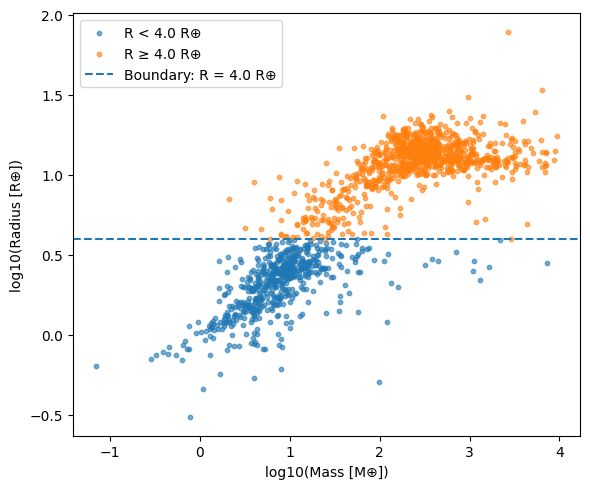

In [80]:
R_BOUND = 4.0
y_bound_log = np.log10(R_BOUND)

small = rad.to_numpy() < R_BOUND
large = ~small

plt.figure(figsize=(6, 5))
plt.scatter(xlog[small], ylog[small], s=10, alpha=0.6, label=f"R < {R_BOUND} R⊕")
plt.scatter(xlog[large], ylog[large], s=10, alpha=0.6, label=f"R ≥ {R_BOUND} R⊕")

plt.axhline(y_bound_log, linestyle="--", linewidth=1.5, label=f"Boundary: R = {R_BOUND} R⊕")

plt.xlabel("log10(Mass [M⊕])")
plt.ylabel("log10(Radius [R⊕])")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


### Create the binary label

- `y = 0` → small planets  
- `y = 1` → large planets


In [81]:
y = (rad.to_numpy() >= R_BOUND).astype(int)

print("Class fractions (0=small, 1=large):")
print(pd.Series(y).value_counts(normalize=True).sort_index())


Class fractions (0=small, 1=large):
0    0.387052
1    0.612948
Name: proportion, dtype: float64


## 4. Train/test split

We use a simple split.

> You may have seen (or will see later) `stratify=y` somewhere else... 
> **Stratification** means “keep the same class fraction in train and test”.  
> We do **not** use it here to keep the code simple, but it’s a good practice when classes are imbalanced.


In [82]:
idx = np.arange(len(y))

idx_train, idx_test = train_test_split(
    idx, test_size=0.25, random_state=RANDOM_STATE
)

print("Train size:", len(idx_train), " | Test size:", len(idx_test))
print("Train fraction of class=1:", y[idx_train].mean())
print("Test  fraction of class=1:", y[idx_test].mean())


Train size: 1089  | Test size: 363
Train fraction of class=1: 0.6198347107438017
Test  fraction of class=1: 0.5922865013774105


## 5. Model A — Logistic regression with one feature: log10(M)

### Step 1: Build X


In [83]:
X_A = xlog.reshape(-1, 1)   # shape (n_samples, 1)

X_A_train = X_A[idx_train]
X_A_test  = X_A[idx_test]

y_train = y[idx_train]
y_test  = y[idx_test]

X_A_train[:5], y_train[:5]


(array([[2.35345106],
        [1.04805317],
        [0.48287358],
        [0.12057393],
        [3.20289643]]),
 array([1, 0, 0, 0, 1]))

### Step 2: Scale features (fit on train, transform train & test)


In [84]:
scaler_A = StandardScaler()
X_A_train_s = scaler_A.fit_transform(X_A_train)
X_A_test_s  = scaler_A.transform(X_A_test)


### Step 3: Fit logistic regression and predict probabilities


In [85]:
clf_A = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)
clf_A.fit(X_A_train_s, y_train)

pA = clf_A.predict_proba(X_A_test_s)[:, 1]     # P(y=1|x)
yA_pred = (pA >= 0.5).astype(int)              # threshold at 0.5


In [86]:
pA[0]

0.12428491584362013

In [87]:
yA_pred[0]

0

### Step 4: Evaluate (confusion matrix + metrics)


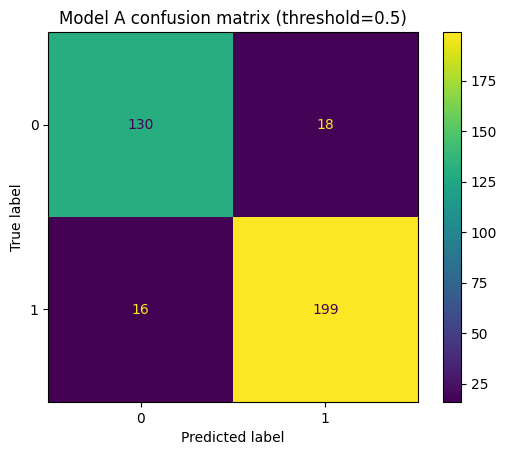

{'accuracy': 0.90633608815427,
 'precision': 0.9170506912442397,
 'recall': 0.9255813953488372,
 'f1': 0.9212962962962963,
 'roc_auc': 0.9579981143934632,
 'avg_precision': 0.9648748793996749,
 'log_loss': 0.25289584654111613}

In [88]:
cm = confusion_matrix(y_test, yA_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Model A confusion matrix (threshold=0.5)")
plt.show()

metrics_A = {
    "accuracy": accuracy_score(y_test, yA_pred),
    "precision": precision_score(y_test, yA_pred, zero_division=0),
    "recall": recall_score(y_test, yA_pred, zero_division=0),
    "f1": f1_score(y_test, yA_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, pA),
    "avg_precision": average_precision_score(y_test, pA),
    "log_loss": log_loss(y_test, pA)    
}
metrics_A


In [89]:
#print(classification_report(y_test, yA_pred))

### ROC and Precision–Recall curves

ROC = Receiver Operating Characteristic


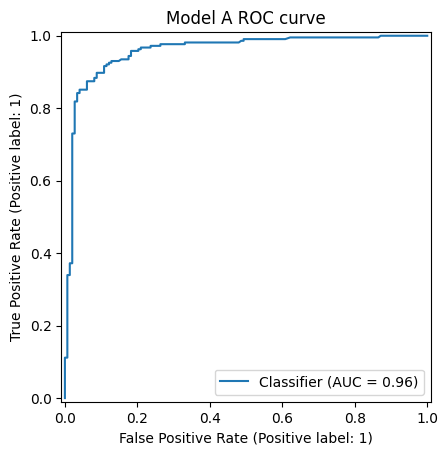

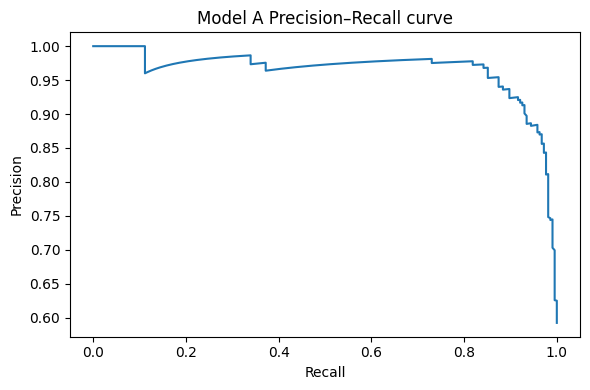

In [90]:
RocCurveDisplay.from_predictions(y_test, pA)
plt.title("Model A ROC curve")
plt.show()

prec, rec, thr = precision_recall_curve(y_test, pA)
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Model A Precision–Recall curve")
plt.tight_layout()
plt.show()


## 6. Model B — Features: log10(M) and Teq

We add `pl_eqt` (equilibrium temperature) as a second feature.

**Important:** Teq has missing values. We will only use rows where Teq is finite and >0.


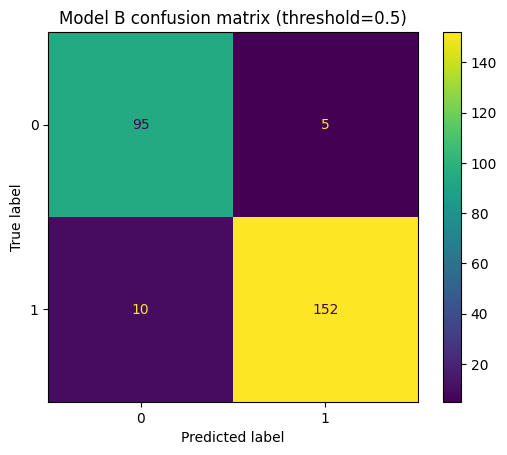

In [91]:
if teq is None:
    print("Teq column not available in this file. Skipping Model B.")
else:
    teq_arr = teq.to_numpy()
    mask_teq = np.isfinite(teq_arr) & (teq_arr > 0)

    xlog_B = xlog[mask_teq]
    teq_B  = teq_arr[mask_teq]
    y_B    = y[mask_teq]

    idxB = np.arange(len(y_B))
    idxB_train, idxB_test = train_test_split(idxB, test_size=0.25, random_state=RANDOM_STATE)

    X_B = np.column_stack([xlog_B, teq_B])
    X_B_train = X_B[idxB_train]
    X_B_test  = X_B[idxB_test]
    yB_train  = y_B[idxB_train]
    yB_test   = y_B[idxB_test]

    scaler_B = StandardScaler()
    X_B_train_s = scaler_B.fit_transform(X_B_train)
    X_B_test_s  = scaler_B.transform(X_B_test)

    clf_B = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)
    clf_B.fit(X_B_train_s, yB_train)

    pB = clf_B.predict_proba(X_B_test_s)[:, 1]
    yB_pred = (pB >= 0.5).astype(int)

    cm = confusion_matrix(yB_test, yB_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title("Model B confusion matrix (threshold=0.5)")
    plt.show()

    metrics_B = {
        "accuracy": accuracy_score(yB_test, yB_pred),
        "precision": precision_score(yB_test, yB_pred, zero_division=0),
        "recall": recall_score(yB_test, yB_pred, zero_division=0),
        "f1": f1_score(yB_test, yB_pred, zero_division=0),
        "roc_auc": roc_auc_score(yB_test, pB),
        "avg_precision": average_precision_score(yB_test, pB),
        "log_loss": log_loss(yB_test, pB),
    }
    metrics_B


In [92]:
#print(classification_report(yB_test, yB_pred))

## 7. Model C — Features: log10(M) and (log10(M))²

This is a **simple feature-engineering** example. We add:
\[
x_1 = \log_{10}(M), \quad x_2 = (\log_{10}(M))^2
\]


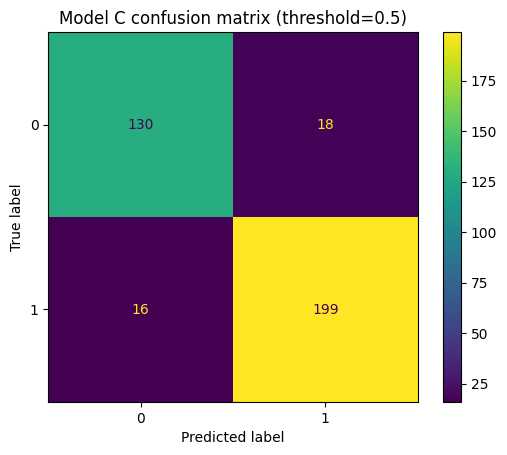

{'accuracy': 0.90633608815427,
 'precision': 0.9170506912442397,
 'recall': 0.9255813953488372,
 'f1': 0.9212962962962963,
 'roc_auc': 0.9579981143934632,
 'avg_precision': 0.9648748793996749,
 'log_loss': 0.2511454310625905}

In [93]:
x1 = xlog
x2 = xlog**2
X_C = np.column_stack([x1, x2])

X_C_train = X_C[idx_train]
X_C_test  = X_C[idx_test]

scaler_C = StandardScaler()
X_C_train_s = scaler_C.fit_transform(X_C_train)
X_C_test_s  = scaler_C.transform(X_C_test)

clf_C = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)
clf_C.fit(X_C_train_s, y_train)

pC = clf_C.predict_proba(X_C_test_s)[:, 1]
yC_pred = (pC >= 0.5).astype(int)

cm = confusion_matrix(y_test, yC_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Model C confusion matrix (threshold=0.5)")
plt.show()

metrics_C = {
    "accuracy": accuracy_score(y_test, yC_pred),
    "precision": precision_score(y_test, yC_pred, zero_division=0),
    "recall": recall_score(y_test, yC_pred, zero_division=0),
    "f1": f1_score(y_test, yC_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, pC),
    "avg_precision": average_precision_score(y_test, pC),
    "log_loss": log_loss(y_test, pC),
}
metrics_C


## 8. Compare the models

Interpretation questions:
- Does Teq help?
- Does the quadratic term help?
- Are changes large or small? Why might that be?


In [94]:
summary = pd.DataFrame([
    {"model": "A: logM", **metrics_A},
    {"model": "C: logM + (logM)^2", **metrics_C},
])

# Add B if it exists
try:
    summary = pd.concat([summary, pd.DataFrame([{"model": "B: logM + Teq", **metrics_B}])], ignore_index=True)
except NameError:
    pass

summary[["model","accuracy","precision","recall","f1","roc_auc","avg_precision","log_loss"]].sort_values("roc_auc", ascending=False)


,model,accuracy,precision,recall,f1,roc_auc,avg_precision,log_loss
2,B: logM + Teq,0.942748,0.968153,0.938272,0.952978,0.966235,0.972758,0.203074
0,A: logM,0.906336,0.917051,0.925581,0.921296,0.957998,0.964875,0.252896
1,C: logM + (logM)^2,0.906336,0.917051,0.925581,0.921296,0.957998,0.964875,0.251145


## 9. Generalization vs optimization, and the role of regularization


- **Generalization** is the *goal*: perform well on unseen data.
- **Regularization** is one *tool* to help generalization by controlling model complexity.

In scikit-learn logistic regression, `C` controls regularization:
- small `C`  → **stronger** regularization
- large `C`  → **weaker** regularization

Below, we plot **train vs test** performance while we change `C`.


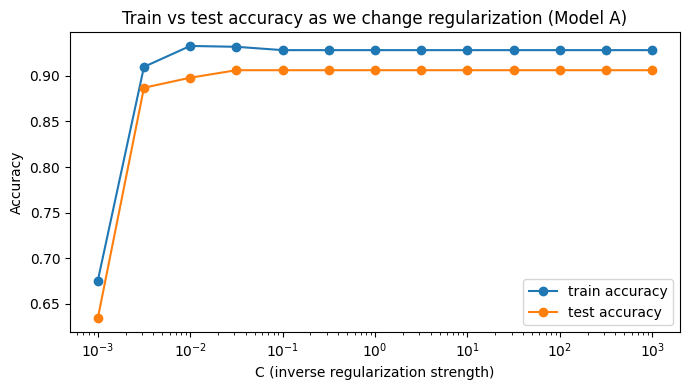

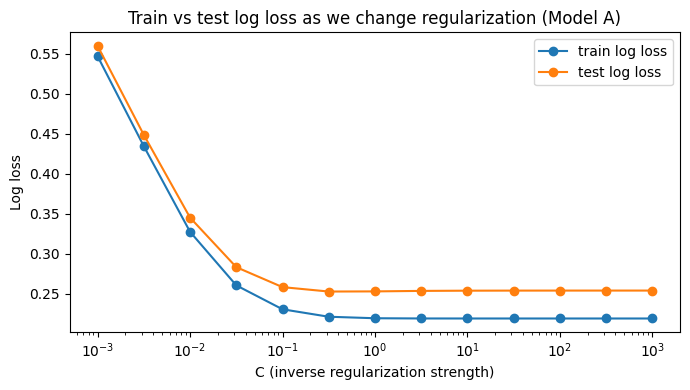

In [95]:
C_values = np.logspace(-3, 3, 13)

train_acc = []
test_acc  = []
train_ll  = []
test_ll   = []

for C in C_values:
    clf = LogisticRegression(max_iter=6000, random_state=RANDOM_STATE, C=C)
    clf.fit(X_A_train_s, y_train)

    p_tr = clf.predict_proba(X_A_train_s)[:, 1]
    p_te = clf.predict_proba(X_A_test_s)[:, 1]

    y_tr = (p_tr >= 0.5).astype(int)
    y_te = (p_te >= 0.5).astype(int)

    train_acc.append(accuracy_score(y_train, y_tr))
    test_acc.append(accuracy_score(y_test, y_te))
    train_ll.append(log_loss(y_train, p_tr))
    test_ll.append(log_loss(y_test, p_te))

plt.figure(figsize=(7,4))
plt.semilogx(C_values, train_acc, marker="o", label="train accuracy")
plt.semilogx(C_values, test_acc, marker="o", label="test accuracy")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Accuracy")
plt.title("Train vs test accuracy as we change regularization (Model A)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.semilogx(C_values, train_ll, marker="o", label="train log loss")
plt.semilogx(C_values, test_ll, marker="o", label="test log loss")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Log loss")
plt.title("Train vs test log loss as we change regularization (Model A)")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation prompt (write 3–4 sentences)

1. For which `C` values do you see signs of **underfitting**?
2. For which `C` values do you see signs of **overfitting**?
3. Is the “best” `C` the one with the lowest training loss? Why?


## 10. Calibration plot (Reliability diagram)

So far we evaluated **classification performance** (precision/recall, ROC, PR curve).  
Now we ask a different question:

> **Are the predicted probabilities well calibrated?**

Meaning:
- among objects with predicted probability ~0.7, is the **true fraction of positives** also ~0.7?

A **reliability diagram** compares:
- x-axis: mean predicted probability in a bin
- y-axis: observed fraction of positives in that bin

A perfectly calibrated model follows the diagonal line \(y=x\).


In [96]:
from sklearn.calibration import calibration_curve


###  Reliability diagram for Model A and B 

We use the test-set probabilities already computed:
- Model A: `pA`
- Model B: `pB`


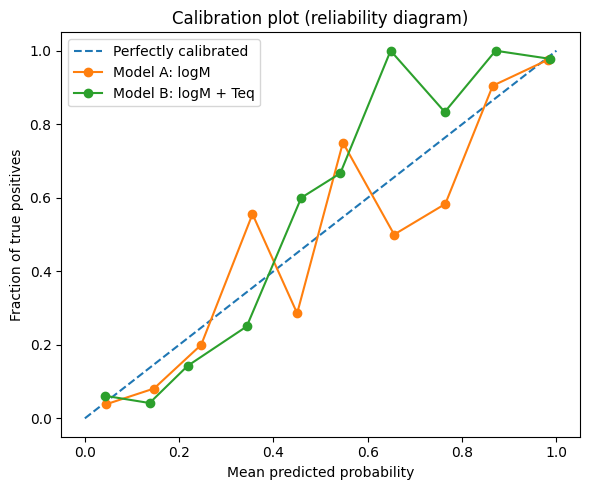

In [97]:
# Choose number of bins (try 10 first)
n_bins = 10

# Model A
prob_true_A, prob_pred_A = calibration_curve(y_test, pA, n_bins=n_bins, strategy="uniform")
prob_true_B, prob_pred_B = calibration_curve(yB_test, pB, n_bins=n_bins, strategy="uniform")

plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.plot(prob_pred_A, prob_true_A, marker="o", label="Model A: logM")
plt.plot(prob_pred_B, prob_true_B, marker="o", label="Model B: logM + Teq")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of true positives")
plt.title("Calibration plot (reliability diagram)")
plt.legend()
plt.tight_layout()
plt.show()


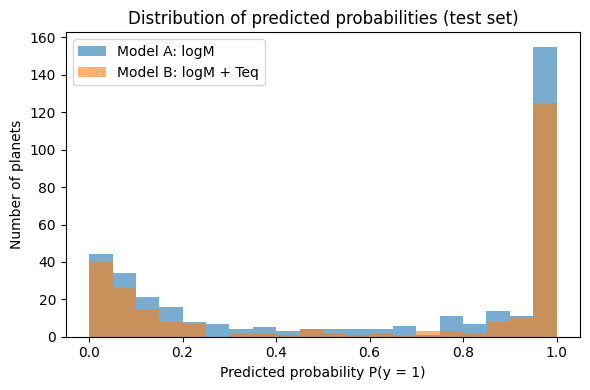

In [98]:
plt.figure(figsize=(6, 4))

plt.hist(pA, bins=20, alpha=0.6, label="Model A: logM")
plt.hist(pB, bins=20, alpha=0.6, label="Model B: logM + Teq")

plt.xlabel("Predicted probability P(y = 1)")
plt.ylabel("Number of planets")
plt.title("Distribution of predicted probabilities (test set)")
plt.legend()
plt.tight_layout()
plt.show()


## 11. Multi-class classification using radius bins (4 classes)

Define classes:
- Class 1: \(R < 2\,R_\oplus\)
- Class 2: \(2 \le R < 4\,R_\oplus\)
- Class 3: \(4 \le R < 8\,R_\oplus\)
- Class 4: \(R \ge 8\,R_\oplus\)


In [99]:

rad_arr = rad.to_numpy()
bins = np.array([0, 2, 4, 8, np.inf])
y_multi = np.digitize(rad_arr, bins) - 1   # labels 0..3

print(pd.Series(y_multi).value_counts().sort_index())


0    224
1    338
2    114
3    776
Name: count, dtype: int64


              precision    recall  f1-score   support

           0      0.780     0.736     0.757        53
           1      0.670     0.768     0.716        95
           2      0.000     0.000     0.000        25
           3      0.912     0.979     0.944       190

    accuracy                          0.821       363
   macro avg      0.590     0.621     0.604       363
weighted avg      0.766     0.821     0.792       363



C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarni

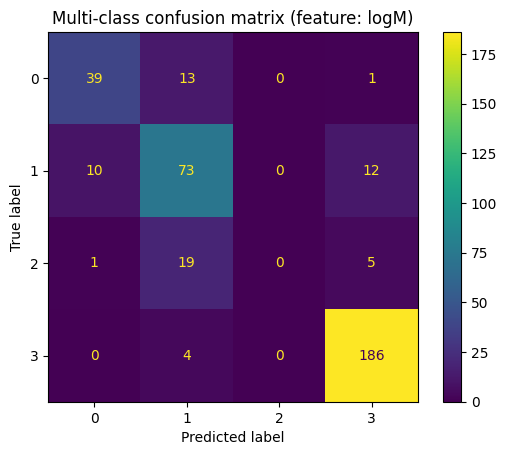

In [100]:
# Features: log_mass only
X_mA = xlog.reshape(-1, 1)

idxm = np.arange(len(y_multi))
idxm_train, idxm_test = train_test_split(idxm, test_size=0.25, random_state=RANDOM_STATE)

X_mA_train = X_mA[idxm_train]
X_mA_test  = X_mA[idxm_test]
y_m_train  = y_multi[idxm_train]
y_m_test   = y_multi[idxm_test]

scaler_m = StandardScaler()
X_mA_train_s = scaler_m.fit_transform(X_mA_train)
X_mA_test_s  = scaler_m.transform(X_mA_test)

clf_m = LogisticRegression(max_iter=9000, random_state=RANDOM_STATE, multi_class="multinomial")
clf_m.fit(X_mA_train_s, y_m_train)

y_m_pred = clf_m.predict(X_mA_test_s)

print(classification_report(y_m_test, y_m_pred, digits=3))

cm = confusion_matrix(y_m_test, y_m_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Multi-class confusion matrix (feature: logM)")
plt.show()


## 12. Student challenge 

1. For the **binary** task, tune the threshold for Model A to achieve **precision ** or as high as possible. Report recall.
2. Compare Models A, B, C using **ROC AUC** and **PR AUC**. Which improvement is more meaningful?
3. *(Bonus)* Repeat multi-class using Model B features (logM + Teq), if Teq exists.


In [101]:
# Challenge helper: choose a threshold achieving target precision for Model A
target_precision = 0.80
prec, rec, thr = precision_recall_curve(y_test, pA)
thr_candidates = thr[prec[:-1] >= target_precision]

if len(thr_candidates) == 0:
    print("No threshold achieves the target precision. Try lowering target_precision.")
else:
    t = thr_candidates.max()
    y_pred_t = (pA >= t).astype(int)
    print("Chosen threshold:", t)
    print({
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
    })


Chosen threshold: 0.9999186171977001
{'accuracy': 0.41046831955922863, 'precision': 1.0, 'recall': 0.004651162790697674, 'f1': 0.009259259259259259}


## 13. Wrap-up

- Logistic regression predicts **probabilities**; labels come from a **threshold**.
- Metrics like **precision/recall** are crucial when classes are imbalanced.
- Model A vs B vs C shows how adding features or simple feature engineering can change performance.
- **Generalization** (test performance) is the goal; **regularization** is one tool to help generalization.
